In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
# import torchmetrics as thm
import LPGNN
import igraph as ig
import networkx as nx
import torch_geometric as pyg

import pyarrow as pa
import pyarrow.parquet as pq

import importlib
import powerlaw

import imageio

from tqdm import tqdm

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-05 16:13:20.962922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 16:13:20.962948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [1]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.embedding)
importlib.reload(LPGNN.poincare_embedding)
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.visualization.degree_distribution)
importlib.reload(LPGNN.visualization)
importlib.reload(LPGNN.utils)
importlib.reload(LPGNN.labne)
importlib.reload(LPGNN.graph_metrics)
importlib.reload(LPGNN.DataSetup)
importlib.reload(LPGNN.tree_pruning)
importlib.reload(LPGNN.LinkPrediction)

NameError: name 'importlib' is not defined

In [180]:
seed = 47

In [187]:
N = 200
avg_k = 8
gamma = 2.7
T = 0.9
seed += 1
PS = LPGNN.popularity_similarity.generatePSNetwork(N, avg_k, gamma, T, seed)

In [186]:
PS = LPGNN.DataSetup.train_test_split(PS, test_ratio=0.4, val_ratio=0, neg_samples=False)
PS_nx = pyg.utils.to_networkx(PS, to_undirected=True)
nx.is_connected(PS_nx)

True

In [28]:
PS_Poincare = LPGNN.poincare_embedding.poincare_embedding(PS, epochs=0, init_pos=None)

In [30]:
for i in range(1000):
    fig, ax = LPGNN.popularity_similarity.drawPSNetwork(PS_Poincare, pos_name='PoincareEmbedding_node_polar_positions', polar_projection=True)
    fig.savefig(f'figs/animations/Poincare/PS_Poincare_{i:04}.png')
    plt.close(fig)
    PS_Poincare = LPGNN.poincare_embedding.poincare_embedding(PS, epochs=1, init_pos=PS_Poincare.PoincareEmbedding_node_positions)

In [31]:
with imageio.get_writer('figs/animations/Poincare/PS_Poincare.gif', mode='I', duration=0.03) as writer:
    for i in tqdm(range(1000)):
        image = imageio.imread(f'figs/animations/Poincare/PS_Poincare_{i:04}.png')
        writer.append_data(image)

100%|██████████| 1000/1000 [01:14<00:00, 13.51it/s]


In [34]:
r = LPGNN.labne.radial_ordering(PS_Poincare)
PS_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r

Calculating best minimal value for power law fit


(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

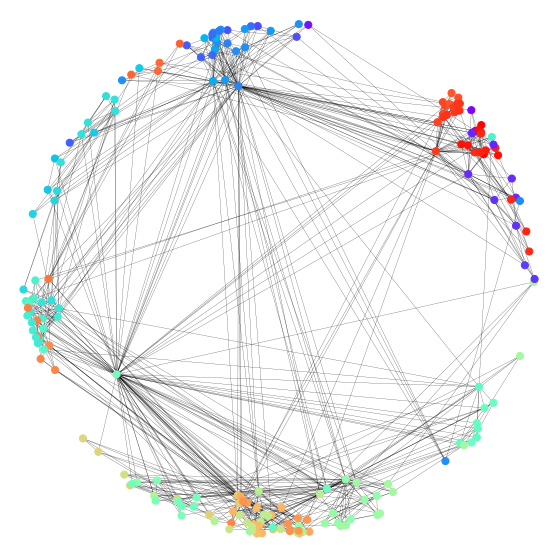

In [37]:
LPGNN.popularity_similarity.drawPSNetwork(PS_Poincare, pos_name='PoincareEmbedding_node_polar_positions', polar_projection=True)

In [72]:
# radial reordering
r = LPGNN.labne.radial_ordering(PS_Poincare)
PS_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
# stretch theta to -pi, pi
PS_Poincare.PoincareEmbedding_node_polar_positions[:,1] %= 2*np.pi
max_theta = PS_Poincare.PoincareEmbedding_node_polar_positions[:,1].max()
min_theta = PS_Poincare.PoincareEmbedding_node_polar_positions[:,1].min()
PS_Poincare.PoincareEmbedding_node_polar_positions[:,1] = (PS_Poincare.PoincareEmbedding_node_polar_positions[:,1] - min_theta) / (max_theta - min_theta) * 2 * np.pi - np.pi

Calculating best minimal value for power law fit


(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

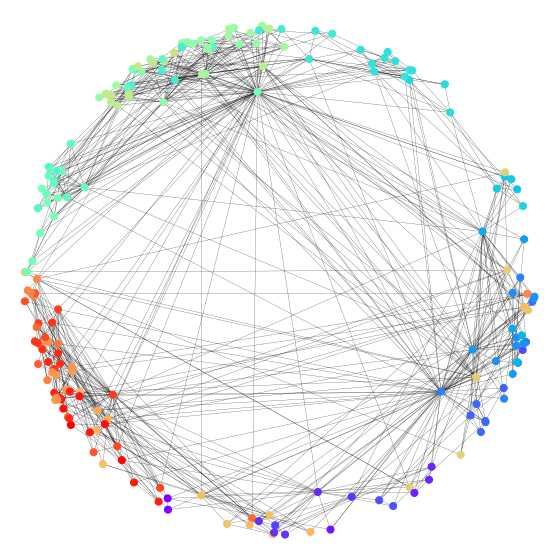

In [73]:
LPGNN.popularity_similarity.drawPSNetwork(PS_Poincare, pos_name='PoincareEmbedding_node_polar_positions', polar_projection=True)

(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

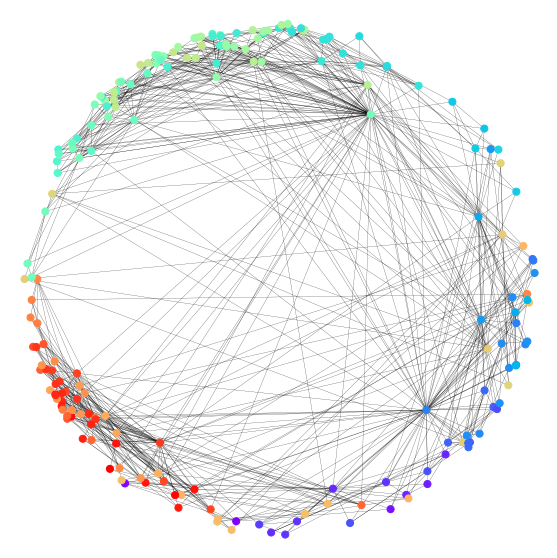

In [75]:
PS_LaBNE.LaBNE_node_polar_positions[:,1] %= 2*np.pi
max_theta = PS_LaBNE.LaBNE_node_polar_positions[:,1].max()
min_theta = PS_LaBNE.LaBNE_node_polar_positions[:,1].min()
PS_LaBNE.LaBNE_node_polar_positions[:,1] = (PS_LaBNE.LaBNE_node_polar_positions[:,1] - min_theta) / (max_theta - min_theta) * 2 * np.pi - np.pi
LPGNN.popularity_similarity.drawPSNetwork(PS_LaBNE, pos_name='LaBNE_node_polar_positions', polar_projection=True)

In [76]:
R_LaBNE, P_LaBNE = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'figs/animations/Poincare/PS_LaBNE', chunk_size=100, skip_file_prep=False, step_size=1)

Generating test mask...
torch.Size([316]) torch.Size([316])
Total test mask:  tensor(316.)  . Total test edges:  316
Generating hyperbolic distances and saving to file  figs/animations/PS_LaBNE
Sorting file...
Reading file and generating precision-recall curve...
index: 19022, R: 1.000, P: 0.017

In [77]:
R_Poincare, P_Poincare = LPGNN.LinkPrediction.precision_recall_score_file(PS_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename=f'figs/animations/Poincare/PS_Poincare', chunk_size=100, skip_file_prep=False, step_size=1)

Generating test mask...
torch.Size([316]) torch.Size([316])
Total test mask:  tensor(316.)  . Total test edges:  316
Generating hyperbolic distances and saving to file  figs/animations/Poincare/PS_Poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 17261, R: 1.000, P: 0.018

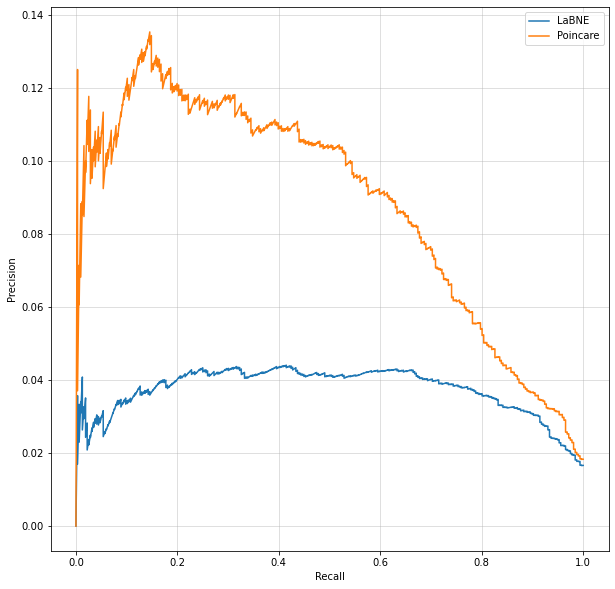

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE, P_LaBNE, label='LaBNE')
ax.plot(R_Poincare, P_Poincare, label='Poincare')
#ax.plot(R_Poincare_more_epochs, P_Poincare_more_epochs, label='Poincare ME')

ax.legend()

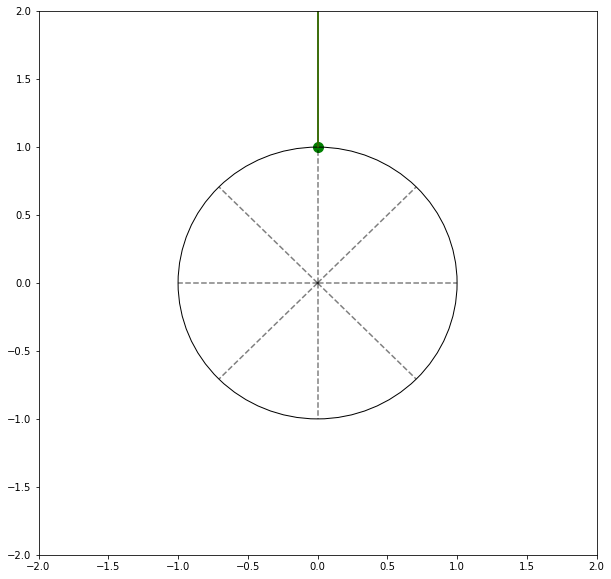

In [176]:
x = th.Tensor([0.0,1])
v = th.Tensor([0,10])
v = x + v

exp_x_v = LPGNN.poincare_embedding.exact_expm(x, v)
a_exp_x_v = LPGNN.poincare_embedding.approx_expm(x, v)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#draw a dot at x
ax.scatter(x[0], x[1], color='g', s=100)

ax.plot([x[0], v[0]], [x[1], v[1]], 'r-')
ax.plot([x[0], exp_x_v[0]], [x[1], exp_x_v[1]], 'b-')
ax.plot([x[0], a_exp_x_v[0]], [x[1], a_exp_x_v[1]], 'g-')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# draw a circle of radius 1 centered at (0,0)
circle = plt.Circle((0, 0), 1, color='k', fill=False)
ax.add_artist(circle)

# draw 8 line segments from the origin to the circle
# make the segments dotted and slightly transparent
for i in range(0, 360, 45):
    ax.plot([0, np.cos(i*np.pi/180)], [0, np.sin(i*np.pi/180)], 'k--', alpha=0.5)